# 4. Project prototype (implementation)

Important note: Whenever I include code other than my own I always include the soruce of the code right above it. If a code snippet doesn't include a reference to a source, you should assume it's done by me.

## Install Dependencies and import libraries

In [1]:
# pip install pandas numpy yfinance pandas-ta scikit-learn tensorflow

In [2]:
# https://pypi.org/project/yfinance/ (""" it's an open-source tool that uses Yahoo's publicly available APIs, and is intended for research and educational purposes. """)
# import yfinance, our data source
import yfinance as yf

# https://pypi.org/project/pandas-ta/ ("""An easy to use Python 3 Pandas Extension with 130+ Technical Analysis Indicators. Can be called from a Pandas DataFrame or standalone""")
# import pandas-ta
import pandas_ta as ta

# import pandas and numpy
import pandas as pd 
import numpy as np

# import matplotlib for data visualisation
import matplotlib.pyplot as plt

# import from scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

# import from tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Input, GRU
from tensorflow.keras.utils import to_categorical

## Select and download the stocks histroical prices data

For this prototype we will consider the following stocks from the S&P500 index.
we will take 5 random stocks from the S&P500 index list.
<br>
Ranks are as of June 6, 2024 from https://www.slickcharts.com/sp500[9]
- Rank 48 Pfizer Inc. 'PFE'
- Rank 150 Roper Technologies, Inc. 'ROP'
- Rank 251 Xylem Inc 'XYL'
- Rank 350 Corpay, Inc. 'CPAY'
- Rank 450 Incyte Genomics Inc 'INCY'

In [3]:
# insert the stock symbols into a list
symbols_list = ['PFE', 'ROP', 'XYL', 'CPAY', 'INCY']

For now we will download the selected stocks weekly price data for the last 10 years

In [4]:
# we will take the weekly data for the last 10 years
# data_weekly = yf.download(symbols_list, period='10y', interval='1wk')

## Format the data and save it as a CSV file

Reshape the dataframe so it has the ticker as a second index

In [5]:
# source of inspiration: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.stack.html[10]
# Return a reshaped DataFrame having a multi-level inde
# stacked_data_weekly = data_weekly.stack()
# stacked_data_weekly

#### What are we looking at?
Date: one of the indexes and is the date in which the information on the reset of the columns takes place.
<br>
Ticker: an abbreviation of the company's share listed on the exchanges.
<br>
Adjusted close: is the closing price after adjustments for all applicable splits and dividend distributions.
<br>
Close: is the closing price of the stock, on that timeframe, (here it's a week).
<br>
High: is the highest point a stock has reached in the given timeframe.
<br>
Low: is the lowest point a stock has reached in the given timeframe.
<br>
Open: the opening price of the stock on that timeframe.
<br>
Volume: the volume of stocks were traded on that timeframe.

<br>

Usually for this type of models we would only keep either Adjusted close or close but we will leave theme both for now.

Save the data to a CSV so we don't have to make any extra unnecessary requests to the API every time we reload the notebook

In [6]:
# save the dataframe to a csv file
# stacked_data_weekly.to_csv('stacked_data_weekly_1.csv', index=True)

# load the the dataframe from the csv file
df = pd.read_csv('stacked_data_weekly_1.csv').set_index(["Date", "Ticker"])

In [7]:
# df.head(5)

## Perform simple exploritory data analysis

In [8]:
# how many null values in each column
df.isnull().sum()

Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [9]:
# the data shape
df.shape

(2615, 6)

In [10]:
# data basic stats
df.describe()

,Adj Close,Close,High,Low,Open,Volume
count,2615.000000,2615.000000,2615.000000,2615.000000,2615.000000,2.615000e+03
mean,144.165301,147.598917,151.117521,143.524492,147.284862,3.118655e+07
std,125.341165,125.626836,127.977518,122.748919,125.314164,5.983749e+07
min,18.176517,25.400000,26.170000,25.200001,25.580000,3.771000e+05
25%,47.719940,51.580000,52.844999,50.285000,51.695000,2.756700e+06
50%,94.846069,95.919998,99.419998,92.790001,96.489998,4.932200e+06
75%,208.165001,209.534996,215.550003,203.775002,209.764999,9.492550e+06
max,570.140015,570.140015,574.289978,556.640015,567.109985,6.333997e+08


## Devide the data into five dataframes, one for each stock

In [11]:
# source of inspiration https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.xs.html [11]
# select specific stock data at the 'Ticker' level of this multi index dataframe
df1 = df.xs('PFE', axis=0, level='Ticker', drop_level=True)
df2 = df.xs('ROP', axis=0, level='Ticker', drop_level=True)
df3 = df.xs('XYL', axis=0, level='Ticker', drop_level=True)
df4 = df.xs('CPAY', axis=0, level='Ticker', drop_level=True)
df5 = df.xs('INCY', axis=0, level='Ticker', drop_level=True)

# disply the first dataframe
df1.head(5)

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2014-07-14,19.895063,29.155598,29.174574,28.785580,28.965843,25720973
2014-07-21,19.545464,28.643265,29.136621,28.538898,28.870968,96927527
2014-07-28,18.684397,27.381405,28.927895,27.220114,28.263758,178002365
2014-08-04,18.509615,26.888046,27.476280,26.442125,27.466793,143172198
2014-08-11,18.705553,27.172676,27.419355,26.593927,27.068312,107166188


In [12]:
# show the new df shape
df1.shape

(523, 6)

## Create the target of the model

Now after this point in the prototype we will only work with df1 which includes the historical stock prices data for the last 10 years for Pfizer Inc. or 'PFE'. This is so we don't make the this prototype too lengthy. However you can easily tell that it's going to be the exact same steps we can follow to train the model on any of the other 4 stocks dataframes. For the final project report we will include at least 5 different stocks data to make sure that our model generalises well.

We are going to try and predict the stock trend based on its past data, that is we will try to predict if the stock price will go up or down, if we know the stock price will go up in the future, we can buy it now and sell it for a profit if the model estimation were correct. also if we know the stock will go down in the future, we can sell it (or short it) now, so our assets won't depreciate in value. 

To do that we will create 2 new columns: 
- 'Next' column where the values for this column will be equal to the next closing price. This is will be the target for the regression model.
- 'trend' column where the values for this column will be either 1 or 0 depending on whether the 'Next' closing price will be higher than the closing price. This will be the target for the classification model, which what we will be using in this prototype.

In [13]:
# copy the dateframe before modification so we don't get a warning from jupyter notebook
df1 = df1.copy()

# create the 'Next' column to be equal to the next closing price
# this can be accomplished easily by shifting the close column backward by 1
df1["Next"] = df1['Close'].shift(-1)

In [14]:
# create a function that returns 1 if the the next closing price is higher than current closing price and 0 otherwise.
def assign_trend(row):
    if row['Next'] > row['Close']:
        return 1
    elif row['Next'] < row['Close']:
        return 0
    else: # if the next value is missing then return NaN
        return np.nan


# create the 'Trend' column to be equal to the output of the 'assign_trend' function    
df1['Trend'] = df1.apply(assign_trend, axis=1)

In [15]:
# check out the results
df1.head(5)

,Adj Close,Close,High,Low,Open,Volume,Next,Trend
Date,,,,,,,,
2014-07-14,19.895063,29.155598,29.174574,28.785580,28.965843,25720973,28.643265,0.0
2014-07-21,19.545464,28.643265,29.136621,28.538898,28.870968,96927527,27.381405,0.0
2014-07-28,18.684397,27.381405,28.927895,27.220114,28.263758,178002365,26.888046,0.0
2014-08-04,18.509615,26.888046,27.476280,26.442125,27.466793,143172198,27.172676,1.0
2014-08-11,18.705553,27.172676,27.419355,26.593927,27.068312,107166188,27.438330,1.0


Check if the data is balanced

In [16]:
# let's check the occurance of each value in the Trend column
df1['Trend'].value_counts()

Trend
1.0    269
0.0    249
Name: count, dtype: int64

In [17]:
df1['Trend'].value_counts()[1]

269

In [18]:
# percentage of 'trend up' to the whole column
df1['Trend'].value_counts()[1]/df1.shape[0]

0.51434034416826

We notice that the data is very balanced in this dataframe. This is good because it will mean the model will be less prone to overfitting.

## Create a common sense baseline
It's essential to start our model development by setting a common sense baseline, this is important because we need to make sure the model we will create, will atleast match this logical baseline, otherwise we will be better off not relying on the model at all.
For this problem, stock prediction, a reasonable assumption is to assume the average person will predict the future trend of the stock to be equal to its current trend. In other words if the stock is going up, this person will think it will go up again and vise versa. This is actually a very solid baseline as it's very reminiscent of the real life. This is has something to do with the topic of behaviorl finance[12] but it's outside the scope of this project.

In [19]:
# this can be accomplished easily by shifting the trend column forward by 1
common_sense = df1['Trend'].shift(1)

# measure the average of when the common sense (naive) prediction will match the actual 'Trend'
(common_sense == df1['Trend']).mean()

0.5239005736137667

This means if a person make a prediction in this method, they will be 52% of the time correct!

## Include the technical indicators
Adding indictors to the dataframe is an essential steps in improving the model performce, as these will be consiered among the model features list and can have a massive benefits on the model performance.
<br>
There are two ways to include technoical indicators, we can do it manually, which will take a lost of time, and reseach, as well as it's more prone to mistakes. We can also utlize an existing library for this very purpose.
<br>
That's why we will be utilizing the pandas-ta library which not only includes most of the nessarry technical indicators we need to calculate, but it's also designed specifically to work on pandas dataframs which is ideal in our case.

We will use pandas-ta to add all the technical indicators we want to the dataframe 

In [20]:
#  we can easily check the available indicators in the pandas-ta library
# help(df1.ta.indicators())

We notice there are a large list of indicators that we can add easily to our dataframe. This is important for the final report because all the indicators we might need are already available, so we can systematically study each one of them, add them to our features list, and test their impact on the model performance.

In [21]:
#  we can also learn about any specific indicator like this
# help(ta.macd)

For this prototype we will only consider few of the most common technical indicators that are used by analysts and ML models to make an estimation of the stock trend direction.
These are MACD, RSI, SMA, and EMA.
the ta.macd function also returns Signal, and Histogram values. so we will add those too.

In [22]:
# for the time being let's create a function that add all the technical indicators we want to a df
def assign_TIs(_df):
    # apply macd on the Close column in a df and add it to the dataframe    
    mcda = ta.macd(_df["Close"])
    # The MACD (Moving Average Convergence/Divergence) is a popular indicator to that is used to identify a trend
    _df.insert(6, "MACD", mcda["MACD_12_26_9"])
    # Signal is an EMA (exponential moving average) of MACD
    _df.insert(7, "Signal", mcda["MACD_12_26_9"])
    # Histogram is the difference of MACD and Signal
    _df.insert(8, "Histogram", mcda["MACD_12_26_9"])
    
    # apply RSI on the Close column in a df and add it to the dataframe    
    # RSI (Relative Strength Index) is popular momentum oscillator. Measures velocity and magnitude a trend
    rsi = ta.rsi(_df["Close"])
    _df.insert(9, "RSI", rsi)
    
    # apply SMA on the Close column in a df and add it to the dataframe    
    # SMA (Simple Moving Average) is the classic moving average that is the equally weighted average over n periods.
    sma = ta.sma(_df["Close"])
    _df.insert(10, "SMA", sma)
    
    # apply EMA on the Close column in a df and add it to the dataframe    
    # EMA (Exponential Moving Average). The weights are determined by alpha which is proportional to it's length.
    ema = ta.ema(_df["Close"])
    _df.insert(11, "EMA", ema)
    
    return _df

In [23]:
# apply the function to the dataframe
df1 = assign_TIs(df1)

In [24]:
# drop the NaN values
df1.dropna(inplace=True)

In [25]:
# fix the 'Trend' data type to be int
df1 = df1.astype({'Trend': int})

In [26]:
# check the dataframe
df1.head(5)

,Adj Close,Close,High,Low,Open,Volume,MACD,Signal,Histogram,RSI,SMA,EMA,Next,Trend
Date,,,,,,,,,,,,,,
2015-01-05,21.509281,30.977230,31.024668,29.421251,29.743834,149756432,0.987145,0.987145,0.987145,64.138291,29.636622,29.674931,31.119545,1
2015-01-12,21.608099,31.119545,31.527514,30.474382,30.996204,145315401,1.041722,1.041722,1.041722,64.864548,29.909867,29.937588,30.787476,0
2015-01-19,21.377520,30.787476,31.783682,30.407970,31.280834,138244854,1.046121,1.046121,1.046121,61.723513,30.110057,30.092113,29.648956,0
2015-01-26,20.586981,29.648956,31.641365,29.601519,30.806452,180924897,0.946823,0.946823,0.946823,52.361419,30.185958,30.011539,31.470589,1
2015-02-02,21.851845,31.470589,31.707781,29.430740,29.829222,197528769,1.003551,1.003551,1.003551,62.232156,30.377609,30.276821,32.865276,1


In [27]:
# the shape of the data now
df1.shape

(493, 14)

##  Prepare the data for training

We start by removing the unnecessary columns, only 'Date' for now.

In [28]:
# reset the index
df1.reset_index(inplace = True)

# drop the Date column as it's not necessary for now
df1.drop(['Date'], axis=1, inplace=True)

# df1.head(5)

Create the features list, for now we will use every column except the last two.

In [29]:
# The features list
X1 = df1.iloc[:, :-2]

X1.head(2)

,Adj Close,Close,High,Low,Open,Volume,MACD,Signal,Histogram,RSI,SMA,EMA
0,21.509281,30.977230,31.024668,29.421251,29.743834,149756432,0.987145,0.987145,0.987145,64.138291,29.636622,29.674931
1,21.608099,31.119545,31.527514,30.474382,30.996204,145315401,1.041722,1.041722,1.041722,64.864548,29.909867,29.937588


Create the target, which is the 'Trend' column for now.

In [30]:
# The Target (Trend for now)
y1 = df1.iloc[:, -1]

Scaling numerical data is an important step before training machine learning models as it reduces the impact of outliers on the output of the model, giving us more accurate predictions.
<br>

Since the features are all numercial data, we can scale them easily to a value in the range of 0 to 1 using scikit-learn minmax scaler.

In [31]:
# initialize a MinMaxScaler instance for a range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# pass the features to the scaler
scaled_X1 = scaler.fit_transform(X1)

# scaled_X1

Now How are we going to actually predict the trend of a stock for the next week? For now we are going to look back at the last 6 weeks and make a prediction based on that. This is how we are going to train the model therefore we need to reshape the data to be in a sequence of 6 timesteps, (6 rows of data). This is a necessary step for RNN models as the input data need to have the shape of (samples, timesteps, number of features)

In [32]:
# source of isnpiration: https://stackoverflow.com/questions/47945512/how-to-reshape-input-for-keras-lstm?rq=4 [13]
# create a function to reshape X and y into sequences of x timesteps
def create_seqs(features, target, num_rows):
    # create 2 empty lists to store the newly shaped features and target lists
    X, y = [], []
    
    # iterate over the features
    for i in range(len(features) - num_rows):
        # create indexes of the start and end of each sequence
        seq_s = i
        seq_e = i + num_rows
        
        # the ith sequence will be a slice of the features between the indexes, create it and add it to X
        xi = features[seq_s : seq_e]
        X.append(xi)
        
        # do the same for the target and add it to y
        yi = target[seq_e]
        y.append(yi)
    
    # return the X and y as numpy arraies
    return np.array(X), np.array(y)

In [33]:
# Create sequences
timesteps = 6
X_seq1, y_seq1 = create_seqs(scaled_X1, y1, timesteps)

In [34]:
# check the new shapes for the features and labels sets
X_seq1.shape, y_seq1.shape

((487, 6, 12), (487,))

In [35]:
# source: https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical [14]
# use to_categorical from tf to converts the target (Trend) to binary class matrix
y_seq1 = to_categorical(y_seq1)

Devide the data into a training set and a test set in 70-30 ratio

In [36]:
#  sets the training test ratio to be 70-30
training_ratio = int(len(X_seq1) * 0.7)

# # split the data into training and test
X1_train, X1_test = X_seq1[:training_ratio], X_seq1[training_ratio:]
y1_train, y1_test = y_seq1[:training_ratio], y_seq1[training_ratio:]

In [37]:
X1_train.shape, X1_test.shape

((340, 6, 12), (147, 6, 12))

## Create and train the baseline classification model
The base line model will be SimpleRNN (simple Recurrent Neural Network) classification model with 3 layers. Input layer, hidden layer both with 64 neurons, and output layer.
The output layer activation function will be 'softmax', and the model optimizer will be 'adam' for now.

In [38]:
# source of inspiration: François Chollet (11, 2017), “Deep Learning with Python” chapter 6 [8]
# construct the model
def create_model():
    # initialize a sequential model
    model = Sequential()
    
    # add the model layers
    model.add(SimpleRNN(64, input_shape=(timesteps, X1_train.shape[2]), return_sequences=True))
    model.add(SimpleRNN(64, return_sequences=False))
    model.add(Dense(2, activation='softmax'))

    # compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [39]:
# initialize the model
model1 = create_model()

C:\Users\ammaroAsus\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
# get the model weights before training
# model1.get_weights()

In [41]:
# train the model
history = model1.fit(X1_train, y1_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)

## Model evaluation and prototype conclusion

In [42]:
# test the model accuracy
model1.evaluate(X1_test, y1_test, verbose=2)

5/5 - 0s - 5ms/step - accuracy: 0.5170 - loss: 0.8761


[0.8761386871337891, 0.5170068144798279]

Training this model takes only few seconds, and the accuracy after initialising and training the model few times we sometimes get an accuracy score that matches our common sense base line or slightly beat it, we can tell it's already higher than IBRAHIM KARATAS(2023)[7] work.
<br>

We can also confirm this by getting the precision and f1-score.

In [43]:
# get predictions from the model given the test set
y1_pred = model1.predict(X1_test)

# source of inspiration: https://stackoverflow.com/questions/48987959/classification-metrics-cant-handle-a-mix-of-continuous-multioutput-and-multi-la [15]
# convert the predictions and test set to be in the shape of a vector of labels
y1_pred_labels = np.argmax(y1_pred, axis=1)
y1_test_labels = np.argmax(y1_test, axis=1)

# get precision, recall, and fscore
precision, recall, fscore, support = precision_recall_fscore_support(y1_test_labels, y1_pred_labels, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F-score:", fscore)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Precision: 0.5323474670632888
Recall: 0.5170068027210885
F-score: 0.5091121770708936


Display the confusion matrix.

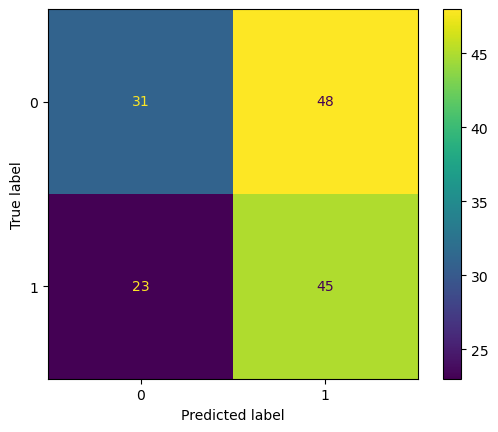

In [44]:
# source of inspiration: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html [16]
conf_mat = confusion_matrix(y1_test_labels, y1_pred_labels)
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
plt.show()

Looking at the following plot, we can see that we are hitting the vanishing returns point before we reach the 15th epoch, this means increasing the epochs will not help us at this point.

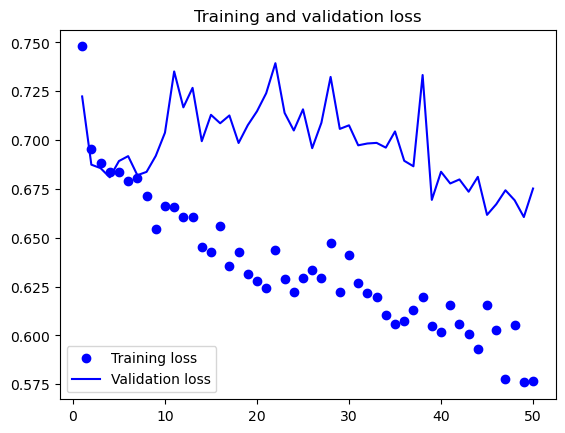

In [45]:
# source of the code snippet[17]
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [46]:
# get the model summary
# model1.summary()

In [47]:
# get the model compile configurations
# model1.get_compile_config()

In [48]:
# get the model configurations after training
# model1.get_config()

In [49]:
# get the model weights after training
# model1.get_weights()

Get a prediction from the model given the last 6 weeks. This is to simulate how a user would get a prediction from the model. The input will be the last entry in the test set.

In [50]:
# reshape the input so it have the shape (1, 6, 12) which what the model expect as input
_input = X1_test[-1].reshape(1, X1_test.shape[1], X1_test.shape[2])
pred = model1.predict(_input)
print(f"Trend: {np.argmax(pred)}, ",f"Confidence: {np.max(pred)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Trend: 1,  Confidence: 0.7864111065864563


From here, we can start iteratively building more accurate models. The final product should look like the following snippet, where users interact with the model through a dictionary of dictionaries. Each dictionary includes the associated models and their functionalities for a given stock symbol.

In [51]:
# this is just an example for iillustrative purposes
# {
#     'PFE': 
#     {
#         'classification_model': {'model': model1, 'interval': 'week', 'predict_function':model1_predict}, 
#         'regression_model': {'model': None, 'interval': 'week', 'predict_function':None}
#     }, 
# }

Now that we created our first model, let's create some other models so we can compare their performance against each others.
<br>
For now we will only add an LSTM model (Long short-term memory recurrent neural network) and GRU model (Gated recurrent unit).

### LSTM

In [52]:
# construct LSTM the model
def create_LSTM_model():
    # initialize a sequential model
    model = Sequential()
    
    # add the model layers
    # input layer
    model.add(Input(shape=(timesteps, X1_train.shape[2])))
    
    # first dense layer
    model.add(LSTM(64, return_sequences=True))
    
    # second dense layer
    model.add(LSTM(64, return_sequences=False))
    
    # output layer
    model.add(Dense(2, activation='softmax'))

    # compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

5/5 - 0s - 5ms/step - accuracy: 0.4830 - loss: 0.7560
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Precision: 0.5397237682951969
Recall: 0.48299319727891155
F-score: 0.3897119698943407


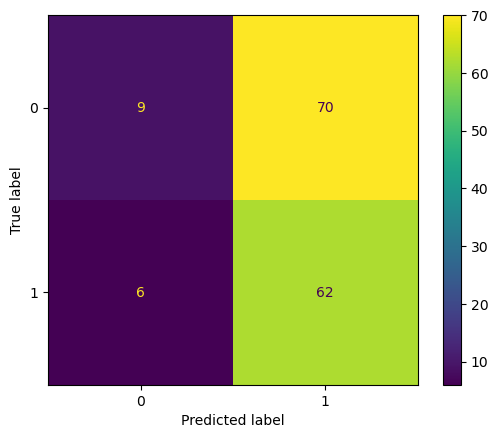

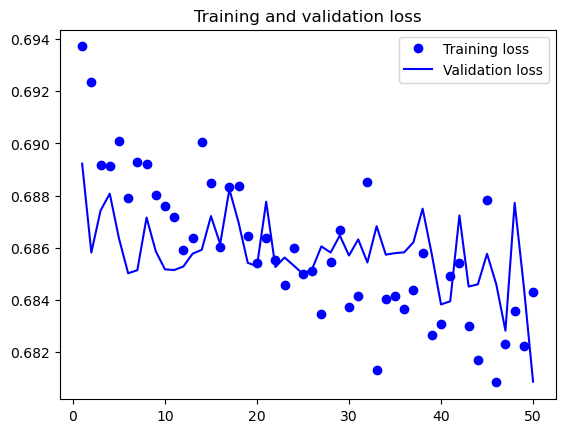

In [53]:
# initialize the model
model1 = create_LSTM_model()

# train the model
history = model1.fit(X1_train, y1_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)

# test the model accuracy
model1.evaluate(X1_test, y1_test, verbose=2)

# get predictions from the model given the test set
y1_pred = model1.predict(X1_test)

# source of inspiration: https://stackoverflow.com/questions/48987959/classification-metrics-cant-handle-a-mix-of-continuous-multioutput-and-multi-la [15]
# convert the predictions and test set to be in the shape of a vector of labels
y1_pred_labels = np.argmax(y1_pred, axis=1)
y1_test_labels = np.argmax(y1_test, axis=1)

# get precision, recall, and fscore
precision, recall, fscore, support = precision_recall_fscore_support(y1_test_labels, y1_pred_labels, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F-score:", fscore)

# source of inspiration: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html [16]
conf_mat = confusion_matrix(y1_test_labels, y1_pred_labels)
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
plt.show()

# source of the code snippet[17]
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### GRU

In [54]:
# source of inspiration: François Chollet (11, 2017), “Deep Learning with Python” chapter 6 [8]
# construct the model
def create_GRU_model():
    # initialize a sequential model
    model = Sequential()
    
    # add the model layers
    # input layer
    model.add(Input(shape=(timesteps, X1_train.shape[2])))
    
    # first dense layer
    model.add(GRU(64, 
                  dropout=0.1, 
                  recurrent_dropout=0.5, 
                  return_sequences=True))
    
    # second dense layer
    model.add(GRU(64,
                  dropout=0.1, 
                  recurrent_dropout=0.5))
    
    # output layer
    model.add(Dense(2, activation='softmax'))

    # compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

5/5 - 0s - 5ms/step - accuracy: 0.4626 - loss: 0.7142
1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/stepWARNING:tensorflow:5 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000024F2FF06340> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Precision: 0.2139849136933685
Recall: 0.46258503401360546
F-score: 0.2926119284923272


C:\Users\ammaroAsus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


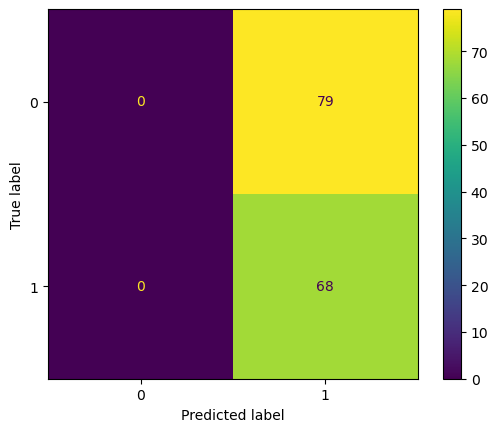

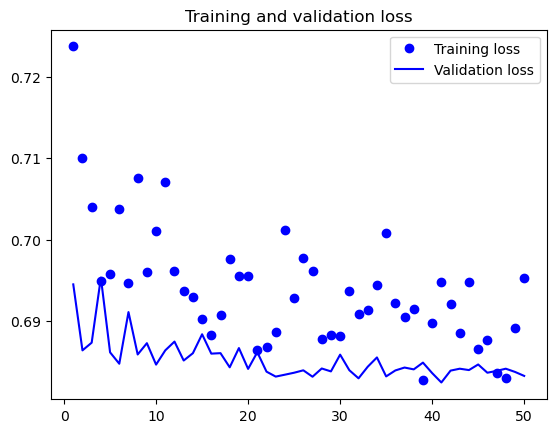

In [55]:
# initialize the model
model1 = create_GRU_model()

# train the model
history = model1.fit(X1_train, y1_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)

# test the model accuracy
model1.evaluate(X1_test, y1_test, verbose=2)

# get predictions from the model given the test set
y1_pred = model1.predict(X1_test)

# source of inspiration: https://stackoverflow.com/questions/48987959/classification-metrics-cant-handle-a-mix-of-continuous-multioutput-and-multi-la [15]
# convert the predictions and test set to be in the shape of a vector of labels
y1_pred_labels = np.argmax(y1_pred, axis=1)
y1_test_labels = np.argmax(y1_test, axis=1)

# get precision, recall, and fscore
precision, recall, fscore, support = precision_recall_fscore_support(y1_test_labels, y1_pred_labels, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F-score:", fscore)

# source of inspiration: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html [16]
conf_mat = confusion_matrix(y1_test_labels, y1_pred_labels)
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
plt.show()

# source of the code snippet[17]
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Notice how the GRU model seems to be incapable of outputting anything but 1. This is an issue that we must address before we actually compare this model with the other ones.

Now le'ts create a regression version of all the 3 models we have so far.
<br>
First let's adjust the target column of the model, for refression the column we are trying to predict is the Next colum.

In [56]:
# The Target (Next for now)
y1_reg = df1.iloc[:, -2]

# Create sequences
timesteps = 6
X_seq1_reg, y_seq1_reg = create_seqs(scaled_X1, y1_reg, timesteps)

# split the data into training and test 70-30 ratio
X1_train_reg, X1_test_reg = X_seq1_reg[:training_ratio], X_seq1_reg[training_ratio:]
y1_train_reg, y1_test_reg = y_seq1_reg[:training_ratio], y_seq1_reg[training_ratio:]

### SimpleRNN regression model

In [57]:
# construct the model
def create_SimpleRNN_Reg_model():
    # initialize a sequential model
    model = Sequential()
    
    # add the model layers
    model.add(Input(shape=(timesteps, X1_train.shape[2])))
    model.add(SimpleRNN(64, return_sequences=True))
    model.add(SimpleRNN(64, return_sequences=False))
    model.add(Dense(1))

    # compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    return model

5/5 - 0s - 4ms/step - loss: 98.3125 - mae: 8.0684
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
R2 score is: -0.04270364949012895


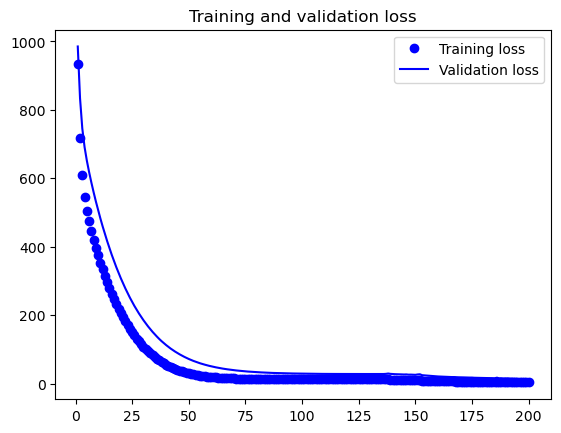

In [58]:
from sklearn.metrics import r2_score

# initialize the model
model1 = create_SimpleRNN_Reg_model()

# train the model
history = model1.fit(X1_train_reg, y1_train_reg, validation_split=0.2, epochs=200, batch_size=32, verbose=0)

# test the model accuracy
model1.evaluate(X1_test_reg, y1_test_reg, verbose=2)

# get predictions from the model given the test set
y1_pred = model1.predict(X1_test_reg)

# get the R2 of the model
r2 = r2_score(y1_test_reg, y1_pred)
print(f"R2 score is: {r2}")


# source of the code snippet[17]
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### LSTM regression model

In [59]:
# construct the model
def create_LSTM_Reg_model():
    # initialize a sequential model
    model = Sequential()
    
    # add the model layers
    model.add(Input(shape=(timesteps, X1_train.shape[2])))
    model.add(LSTM(64, return_sequences=True))    
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(1))

    # compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    return model

5/5 - 0s - 5ms/step - loss: 59.0259 - mae: 6.0010
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
R2 score is: 0.3739699642515384


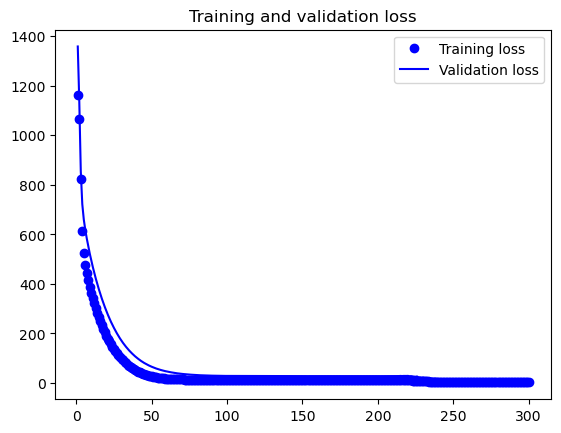

In [60]:
# initialize the model
model1 = create_LSTM_Reg_model()

# train the model
history = model1.fit(X1_train_reg, y1_train_reg, validation_split=0.2, epochs=300, batch_size=32, verbose=0)

# test the model accuracy
model1.evaluate(X1_test_reg, y1_test_reg, verbose=2)

# get predictions from the model given the test set
y1_pred = model1.predict(X1_test_reg)

# get the R2 of the model
r2 = r2_score(y1_test_reg, y1_pred)
print(f"R2 score is: {r2}")

# source of the code snippet[17]
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### GRU regression model

In [61]:
# construct the model
def create_GRU_Reg_model():
    # initialize a sequential model
    model = Sequential()
    
    # add the model layers
    model.add(Input(shape=(timesteps, X1_train.shape[2])))
    model.add(GRU(64, dropout=0.1, recurrent_dropout=0.5, return_sequences=True))
    model.add(GRU(64, dropout=0.1, recurrent_dropout=0.5))
    model.add(Dense(1))

    # compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    return model

5/5 - 0s - 5ms/step - loss: 1341.1838 - mae: 35.2960
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
R2 score is: -13.224618380586763


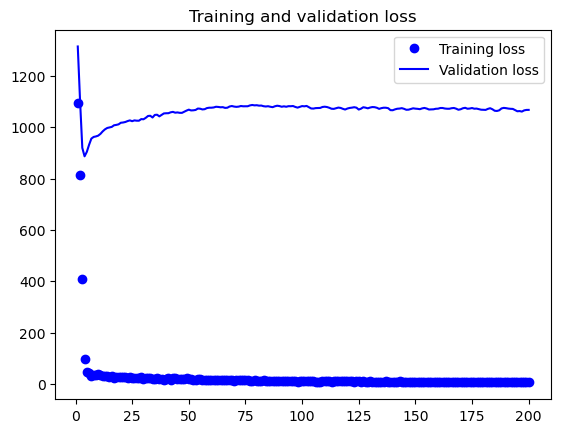

In [62]:
# initialize the model
model1 = create_GRU_Reg_model()

# train the model
history = model1.fit(X1_train_reg, y1_train_reg, validation_split=0.2, epochs=200, batch_size=32, verbose=0)

# test the model accuracy
model1.evaluate(X1_test_reg, y1_test_reg, verbose=2)

# get predictions from the model given the test set
y1_pred = model1.predict(X1_test_reg)

# get the R2 of the model
r2 = r2_score(y1_test_reg, y1_pred)
print(f"R2 score is: {r2}")

# source of the code snippet[17]
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We notice that the GRU model also did perform the worst here, which increase the need to perform further investigation.
<br>
For the other models we got a low R2 score as well as MAE of 6.4-6.9 which doesn't mean a lot until we check the average value of the Next colum which we are trying to predict. this MAE is relatively high and make the regression models not useful for real world usage.

In [63]:
# the average value for the Next closing price to judge weather the mae is acceptable or not 
df1['Next'].mean()

36.691718606387866

## Hyperparameters optimization

We will use RandomizedSearchCV from sikit-learn to perform hyperparameter optimization on the SimpleRNN classification model for now, at this stage we only want to confirm that this approach works, at a later stage we will perform more in depth experiments with different models as well as different Hyperparameters optimization algorithms.
<br>
To perform such operation we need to convert our tensorflow model to be compatible with the scikit-learn library.
To do so we will utilize the scikeras to warp the model first, then perform Hyperparameters optimization tunning on that warpped version of the model. 

In [64]:
# !pip install scikeras

In [65]:
# helper function to measure how long a process would take
from datetime import datetime

def get_time():
    return datetime.now()

In [73]:
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings


# get the time before starting the process
start = get_time()

# source of inspiration: https://stackoverflow.com/questions/72392579/scikeras-randomizedsearchcv-for-best-hyper-parameters [19]
# construct the model
def create_model(n_hidden = 1, n_neurons = 30, learning_rate=3e-3):
    # initialize a sequential model
    model = Sequential()
    
    # create an input layer
    model.add(Input(shape=(timesteps, X1_train.shape[2])))
    
    # add a static first deep layer
    model.add(SimpleRNN(n_neurons, return_sequences=True))

    # add the other model deep layers dynamically
    for layer in range(1, n_hidden):
        model.add(SimpleRNN(n_neurons))
    
    # output layer
    model.add(Dense(2, activation='softmax'))
    
    # create an Adam optimizer with a variable learning rate
    opt = Adam(learning_rate=learning_rate)
    
    # compile the model
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    return model


# define possible parameters (this is just a test for now and we will add more parameters for the final report)
# we need to distingiush between the model building function input and the RandomizedSearchCV input, to do that we prefix the model input with model__
# source: https://adriangb.com/scikeras/stable/notebooks/Basic_Usage.html (7.1 Special prefixes) [20]
params = {
    "model__n_hidden": [0, 1, 2, 3, 4, 5],
    "model__n_neurons": [int(x) for x in np.arange(1, 128)],
    "model__learning_rate": [1e-2, 1e-3, 1e-4], 
    'epochs': [10, 20, 30],
    'batch_size': [16, 32, 64]
}

# create a keras classification model wrappers from the scikeras library which allow us to utilize the hyperparameter tunning functions from the scikit-learn library
kerasWarp = KerasClassifier(model=create_model, verbose=0)

# RandomizedSearchCV
random_simpleRnn_clas = RandomizedSearchCV(estimator=kerasWarp, param_distributions=params, n_iter=10, cv=None, random_state=101)

# source of inspiration: https://stackoverflow.com/questions/40105796/turn-warning-off-in-a-cell-jupyter-notebook [21]
# prevent FitFailedWarning
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    # fit the RandomizedSearchCV models
    random_simpleRnn_clas.fit(X1_train, y1_train, validation_split=0.2)

# print results
print(f"RandomizedSearchCV best parameters: {random_simpleRnn_clas.best_params_}")
print(f"RandomizedSearchCV best score: {random_simpleRnn_clas.best_score_}")


# get the time after finishing the process
end = get_time()

# print the duration
print(f"process finished in: {end - start}")

RandomizedSearchCV best parameters: {'model__n_neurons': 108, 'model__n_hidden': 2, 'model__learning_rate': 0.001, 'epochs': 30, 'batch_size': 16}
RandomizedSearchCV best score: 0.5529411764705883
process finished in: 0:00:46.003049


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4478 - loss: 0.8583 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Precision: 0.574805808848362
Recall: 0.47619047619047616
F-score: 0.3427392009435353


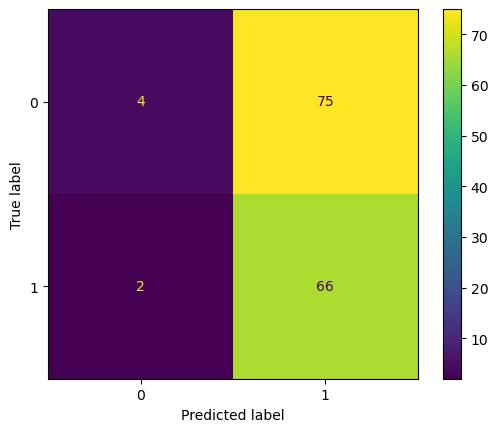

In [74]:
# retrieve the best model and refit on the training data to get the history
best_model = random_simpleRnn_clas.best_estimator_.model_

# evaluate the best model on the test data
best_model.evaluate(X1_test, y1_test, verbose=1)

# get predictions from the model given the test set
y1_pred = best_model.predict(X1_test)

# convert the predictions and test set to be in the shape of a vector of labels
y1_pred_labels = np.argmax(y1_pred, axis=1)
y1_test_labels = np.argmax(y1_test, axis=1)

# get precision, recall, and fscore
precision, recall, fscore, support = precision_recall_fscore_support(y1_test_labels, y1_pred_labels, average='weighted')
print("Precision:", precision)
print("Recall:", recall)
print("F-score:", fscore)

# Confusion Matrix
conf_mat = confusion_matrix(y1_test_labels, y1_pred_labels)
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
plt.show()

In [75]:
# get a summary of the best model
best_model.summary()

Model: "sequential_158"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_308 (SimpleRNN)           │ (None, 6, 108)              │          13,068 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_309 (SimpleRNN)           │ (None, 108)                 │          23,436 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_98 (Dense)                     │ (None, 2)                   │             218 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,168 (430.35 KB)

 Trainable params: 36,722 (143.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 73,446 (286.90 KB)

we see we have relatively better results than the base line SimpleRNN classification model when it come to the confussion matrix, which means we are on the right direction.

I also experimented with gridSearchCV from scikit learn as well as Hyperband from keras tuner by following the instructions in this notebook from tensorflow official documentation https://www.tensorflow.org/tutorials/keras/keras_tuner 
<br>
However I will not include that in this draft submission as I ran out of time to add them in a presentable way.

# 5. Evaluation
| Model | Configurations | Results |
| :- | :- | :- |
| baseline SimpleRNN classification model | {layers: (layer1(units=64, return_sequences=True), layer2(units=64, return_sequences=False), output_layer(units=2, activation='softmax')), optimizer='adam', loss='categorical_crossentropy',  epochs=50, batch_size=32} | {accuracy: 0.5102, loss: 0.8259, Precision: 0.5227, Recall: 0.5102, F-score: 0.5047}
| baseline LSTM classification model| {layers: (layer1(units=64, return_sequences=True), layer2(units=64, return_sequences=False), output_layer(units=2, activation='softmax')), optimizer='adam', loss='categorical_crossentropy',  epochs=50, batch_size=32} | {accuracy: 0.4626, loss: 0.7830, Precision: 0.4802, Recall: 0.4625, F-score: 0.3768} |
| baseline GRU classification model | {layers: (layer1(units=64, dropout=0.1, recurrent_dropout=0.5, return_sequences=True), layer2(units=64, dropout=0.1, recurrent_dropout=0.5), output_layer(units=2, activation='softmax')), optimizer='adam', loss='categorical_crossentropy',  epochs=50, batch_size=32} | {accuracy: 0.4626, loss: 0.7179, Precision: 0.2139, Recall: 0.4625, F-score: 0.2926} |
| SimpleRNN regression model | {layers: (layer1(units=64, return_sequences=True), layer2(units=64, return_sequences=False), output_layer(units=1)), optimizer='adam', loss='mean_squared_error', metrics=mae,  epochs=200, batch_size=32} | {loss: 74.4604, mae: 6.9609, R2 score: 0.2103} |
| LSTM regression model | {layers: (layer1(units=64, return_sequences=True), layer2(units=64, return_sequences=False), output_layer(units=1)), optimizer='adam', loss='mean_squared_error', metrics=mae,  epochs=300, batch_size=32} | {loss: 63.3322, mae: 6.4408, R2 score: 0.3283} |
| GRU regression model | {layers: (layer1(units=64, dropout=0.1, recurrent_dropout=0.5, return_sequences=True), layer2(units=64, dropout=0.1, recurrent_dropout=0.5), output_layer(units=1)), optimizer='adam', loss='mean_squared_error', metrics=mae,  epochs=200, batch_size=32} | {loss: 1275.4667, mae: 34.2446, R2 score: -12.5277} |
| SimpleRNN classification model with RandomizedSearchCV Hyperparameters optimization | {'model__n_neurons': 108, 'model__n_hidden': 2, 'model__learning_rate': 0.001, 'epochs': 30, 'batch_size': 16} | {accuracy: 0.4997, loss: 2.6462, Precision: 0.5389, Recall: 0.5238, F-score: 0.5168 } |

# 6. Conclusion
So far we have managed to create a total of 6 baseline models between regression and classification models, we also managed to perform hyperparameter optimization which enhanced the performance of the model we applied. So far all the results are relatively low and barely outperform our established common-sense baseline, however, we must remember that we haven't started doing any feature selection yet, so the training dataset is extremely limited at this stage but we want to establish a robust training pipeline before we start working on our feature selection. This will make our process more organized and yield the best possible results.

I know this is not a complete project but this is what I could come up with since I  only had 4 days to work on this draft, in the past few weeks I didn't work on the final project as I was busy with my other modules midterm, therefore this is not a representation of the final report but just a very early draft.

# 7. References
Note: we used the ACM citation style for the referencing.

[1] Arielle O'Shea (2023). “What is a stock?”. Nerd wallet. (Mar 31, 2023). Retrieved Jun 14, 2024 from https://www.nerdwallet.com/article/investing/what-is-a-stock#:~:text=A%20stock%20is%20a%20security,increases%20in%20value%20as%20well   

[2] “Algorithmic Trading Market - Growth, Trends, COVID-19 Impact, and Forecasts (2022 - 2027)”. Yahoo finance. (Mar 18, 2022). Retrieved Jun 14, 2024 from
https://finance.yahoo.com/news/algorithmic-trading-market-growth-trends-112400870.html 

[3] ADAM HAYES, Gordon Scott, DAVID RUBIN (2024). investopedia.
 “Position Definition—Short and Long Positions in Financial Markets”. (May 31, 2024).  Retrieved Jun 14, 2024 from  https://www.investopedia.com/terms/p/position.asp#:~:text=our%20editorial%20policies-,What%20Is%20a%20Position%3F,short%20securities%20with%20bearish%20intent.  

[4] Nuti, Giuseppe (11/2011). "Algorithmic Trading". Computer (Long Beach, Calif.) (0018-9162), 44 (11), p. 61, Retrieved April 21,2024 from  https://ieeexplore.ieee.org/document/5696713 

[5] Alzaman, Chaher (03/2024). "Deep learning in stock portfolio selection and predictions". Expert systems with applications (0957-4174), 237 , p. 121404, Retrieved April 21,2024 from https://www.sciencedirect.com/science/article/pii/S0957417423019061  

[6] B L, Shilpa (2023). "Deep Learning Models for Stock Market Prediction Using Optimization Approach" in 2023 International Conference on Network, Multimedia and Information Technology (NMITCON) (979-83-503-0083-3), (p. 1), Retrieved April 21,2024 from 
https://ieeexplore.ieee.org/document/10275882  

[7] IBRAHIM KARATAS (2023). “Machine Learning for Stocks Trading”. Kaggle. (2023). Retrieved April 21,2024 from https://www.kaggle.com/code/ibrahimkaratas/machine-learning-for-stocks-trading/notebook  

[8] François Chollet (11, 2017), “Deep Learning with Python”, chapters (6, 7), Manning Publications Co, Retrieved May 14, 2024 from https://www.manning.com/books/deep-learning-with-python  

[9] S&P 500 ETF Components. Slickcharts. (2024). Retrieved June 6, 2024 from https://www.slickcharts.com/sp500  

[10] pandas.DataFrame.stack. Pandas. (2024). Retrieved May 16, 2024 from https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.stack.html  

[11] pandas.DataFrame.xs. Pandas. (2024). Retrieved May 16, 2024 from https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.xs.html  

[12] ADAM HAYES,  ERIC ESTEVEZ, Yarilet Perez (2023). “Behavioral Finance”. “What Is Behavioral Finance?”. investopedia. (Dec 19, 2023). Retrieved Jun 14, 2024 from https://www.investopedia.com/terms/b/behavioralfinance.asp  

[13] mpariente (2017). “How to reshape input for keras LSTM?”.  stack overflow. (Dec 22, 2017). Retrieved May 20, 2024 from https://stackoverflow.com/questions/47945512/how-to-reshape-input-for-keras-lstm?rq=4  

[14] tf.keras.utils.to_categorical. TensorFlow. (2024). Retrieved May 26, 2024 from https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical  

[15] ericheindl (2021), “classification metrics can't handle a mix of continuous-multioutput and multi-label-indicator targets”. stack overflow. (May 11, 2021). Retrieved Jun 15, 2024 from https://stackoverflow.com/questions/48987959/classification-metrics-cant-handle-a-mix-of-continuous-multioutput-and-multi-la  

[16] sklearn.metrics.ConfusionMatrixDisplay. Sci-kit learn. (2024). Retrieved Jun 15, 2024 from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html  

[17] François Chollet (11, 2017), “Deep Learning with Python”, chapters (6), Listing 6.38. Plotting results, Manning Publications Co, Retrieved Jun 15, 2024 from https://www.manning.com/books/deep-learning-with-python 

[18] Dataset obtained using yfinance: https://pypi.org/project/yfinance/ (""" it's an open-source tool that uses Yahoo's publicly available APIs, and is intended for research and educational purposes. """)

[19] ecatanzani (2022), "SciKeras - RandomizedSearchCV for best hyper-parameters". stack overflow. (May 26, 2022). Retrieved Jul 20, 2024 from  https://stackoverflow.com/questions/72392579/scikeras-randomizedsearchcv-for-best-hyper-parameters 

[20] Scikeras tutorials, Basic usage. "7.1 Special prefixes". SciKeras’s documentation (2024). Retrieved jul 21, 2024 from https://adriangb.com/scikeras/stable/notebooks/Basic_Usage.html


[21] mins(2021), pixelistik (2023), "turn warning off in a cell jupyter notebook". stack overflow. (Jan 20, 2021). Retrieved Jul 22, 2024 from https://stackoverflow.com/questions/40105796/turn-warning-off-in-a-cell-jupyter-notebook